In [1]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
# Configuration
base_dir = Path("C:/Users/niels/Projects/Thesis-Code/Saved models/20251120-144239_overfitting_regularization_sweep")
run_prefix = "run_20251120-144239_overfitting_regularization_sweep"
num_jobs = 72

# Load all runs
runs_data = []

for job_id in range(num_jobs):
    run_dir = base_dir / f"{run_prefix}_job{job_id}"
    
    # Read events.jsonl - get last line
    events_file = run_dir / "facts" / "events.jsonl"
    if not events_file.exists():
        print(f"Warning: {events_file} not found")
        continue
    
    with open(events_file) as f:
        lines = [line.strip() for line in f if line.strip()]
        if not lines:
            print(f"Warning: {events_file} is empty")
            continue
        last_event = json.loads(lines[-1])
    
    # Read override.yaml
    override_file = run_dir / ".hydra" / "overrides.yaml"
    overrides = {}
    if override_file.exists():
        with open(override_file) as f:
            for line in f:
                line = line.strip()
                if line.startswith('- '):
                    line = line[2:]  # Remove '- '
                if '=' in line:
                    key, value = line.split('=', 1)
                    overrides[key.strip()] = value.strip()
    
    # Extract hyperparameters
    dropout = float(overrides.get('classifier.model.dropout', 0))
    weight_decay = float(overrides.get('classifier.trainer.weight_decay', 0))
    lr = float(overrides.get('classifier.trainer.lr', 0))
    label_smoothing = float(overrides.get('classifier.trainer.label_smoothing', 0))
    
    # Extract histories from last event - check both histories dict and direct fields
    histories = last_event.get('histories', {})
    history_train_loss = last_event.get('history_train_loss', histories.get('train_loss', []))
    history_val_loss = last_event.get('history_val_loss', histories.get('val_loss', []))
    history_val_auroc = last_event.get('history_val_auroc', histories.get('val_auroc', []))
    
    runs_data.append({
        'job_id': job_id,
        'run_dir': str(run_dir),
        'dropout': dropout,
        'weight_decay': weight_decay,
        'lr': lr,
        'label_smoothing': label_smoothing,
        'history_train_loss': history_train_loss,
        'history_val_loss': history_val_loss,
        'history_val_auroc': history_val_auroc,
    })

print(f"Loaded {len(runs_data)} runs")
df = pd.DataFrame(runs_data)


Loaded 72 runs


# 1. Dropout Analysis


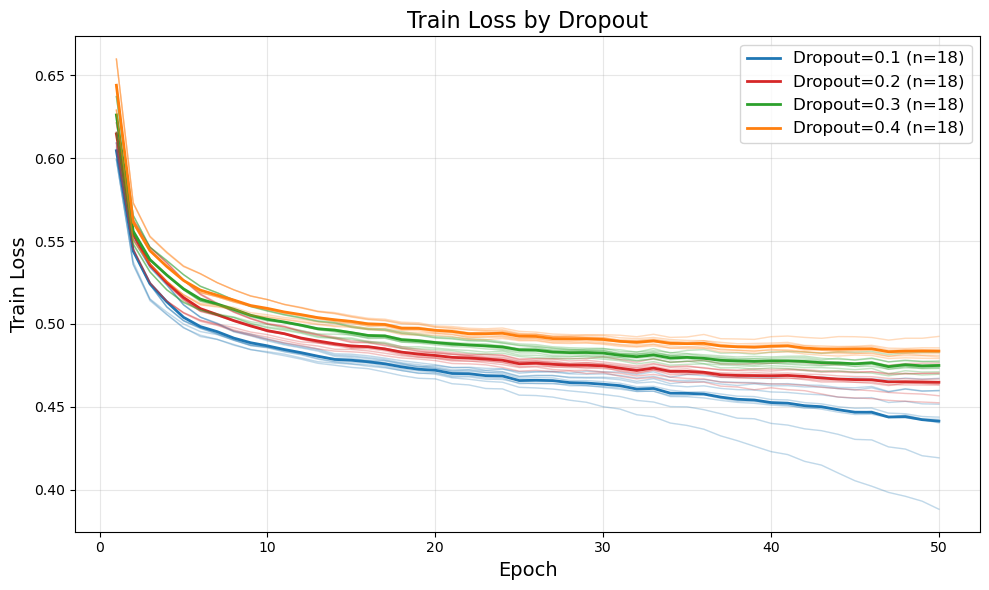

In [3]:
# Group by dropout
dropout_values = sorted(df['dropout'].unique())
# Use highly distinct colors: blue, red, green, orange
distinct_colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors = [distinct_colors[i % len(distinct_colors)] for i in range(len(dropout_values))]

# Train Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, dropout_val in enumerate(dropout_values):
    subset = df[df['dropout'] == dropout_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_train_loss']) + 1)
        ax.plot(epochs, row['history_train_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_train_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_train_losses.append(row['history_train_loss'])
        max_len = max(max_len, len(row['history_train_loss']))
    if all_train_losses:
        # Pad to same length
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_train_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'Dropout={dropout_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Train Loss', fontsize=14)
ax.set_title('Train Loss by Dropout', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


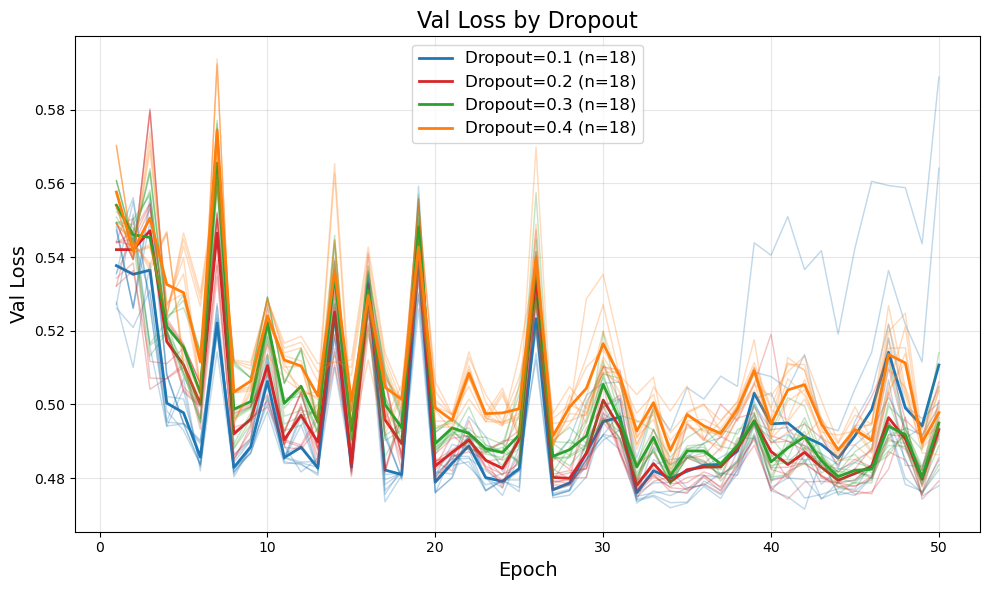

In [4]:
# Val Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, dropout_val in enumerate(dropout_values):
    subset = df[df['dropout'] == dropout_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_val_loss']) + 1)
        ax.plot(epochs, row['history_val_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_val_losses.append(row['history_val_loss'])
        max_len = max(max_len, len(row['history_val_loss']))
    if all_val_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_val_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'Dropout={dropout_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val Loss', fontsize=14)
ax.set_title('Val Loss by Dropout', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


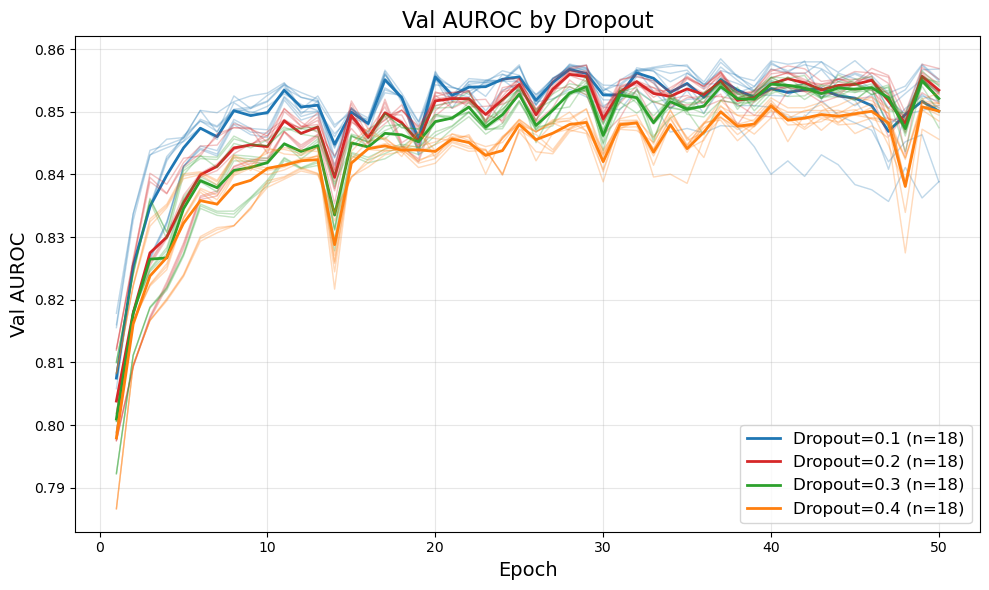

In [5]:
# Val AUROC
fig, ax = plt.subplots(figsize=(10, 6))
for i, dropout_val in enumerate(dropout_values):
    subset = df[df['dropout'] == dropout_val]
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            epochs = range(1, len(row['history_val_auroc']) + 1)
            ax.plot(epochs, row['history_val_auroc'], 
                    color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_aurocs = []
    max_len = 0
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            all_val_aurocs.append(row['history_val_auroc'])
            max_len = max(max_len, len(row['history_val_auroc']))
    if all_val_aurocs:
        padded = [auroc + [auroc[-1]] * (max_len - len(auroc)) if len(auroc) < max_len else auroc 
                 for auroc in all_val_aurocs]
        mean_auroc = np.mean([auroc[:max_len] for auroc in padded], axis=0)
        epochs = range(1, len(mean_auroc) + 1)
        ax.plot(epochs, mean_auroc, color=colors[i], linewidth=2, 
                label=f'Dropout={dropout_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val AUROC', fontsize=14)
ax.set_title('Val AUROC by Dropout', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 2. Weight Decay Analysis


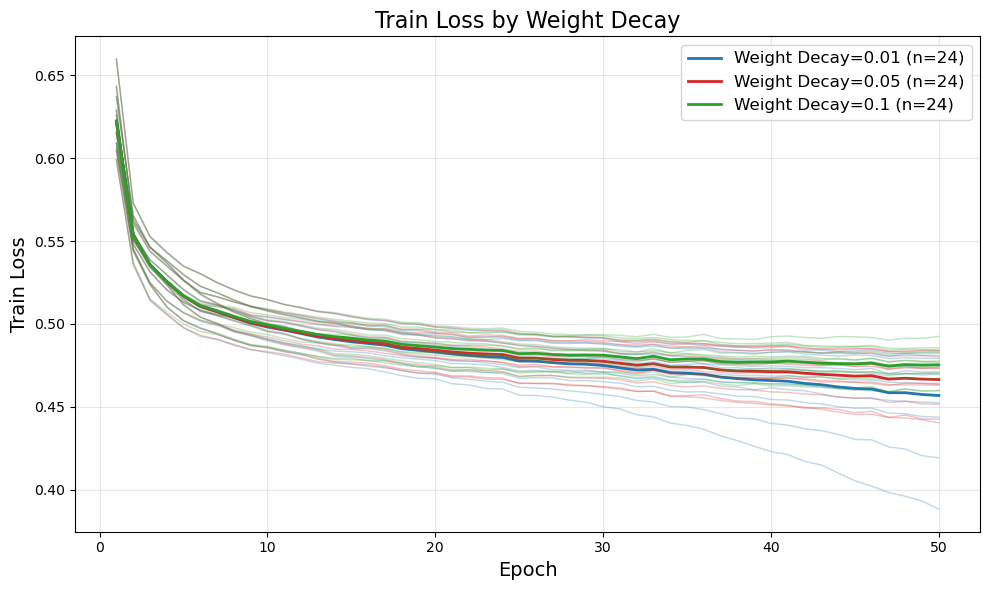

In [6]:
# Group by weight_decay
weight_decay_values = sorted(df['weight_decay'].unique())
# Use highly distinct colors: blue, red, green
distinct_colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors = [distinct_colors[i % len(distinct_colors)] for i in range(len(weight_decay_values))]

# Train Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, wd_val in enumerate(weight_decay_values):
    subset = df[df['weight_decay'] == wd_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_train_loss']) + 1)
        ax.plot(epochs, row['history_train_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_train_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_train_losses.append(row['history_train_loss'])
        max_len = max(max_len, len(row['history_train_loss']))
    if all_train_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_train_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'Weight Decay={wd_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Train Loss', fontsize=14)
ax.set_title('Train Loss by Weight Decay', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


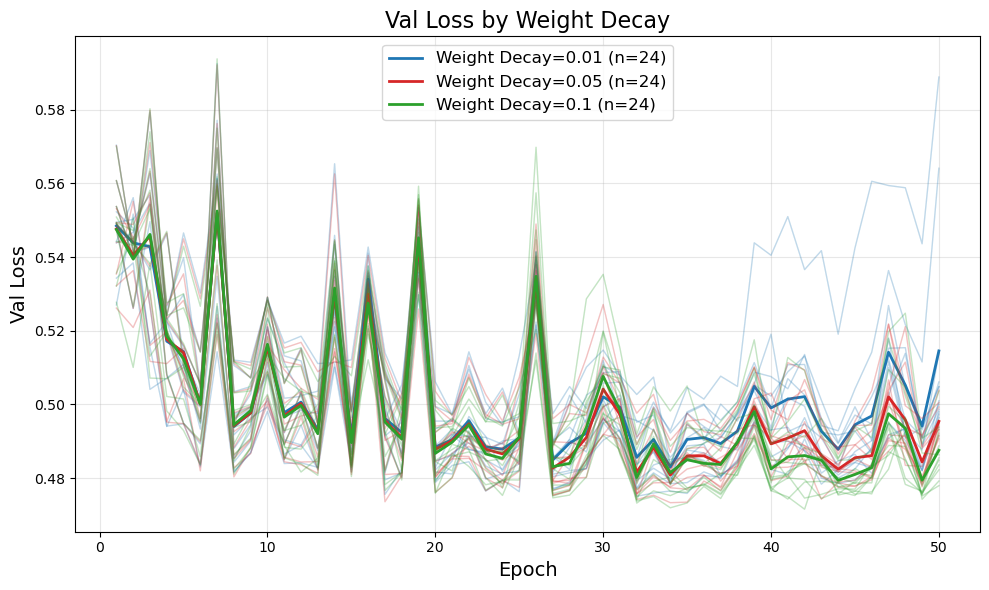

In [7]:
# Val Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, wd_val in enumerate(weight_decay_values):
    subset = df[df['weight_decay'] == wd_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_val_loss']) + 1)
        ax.plot(epochs, row['history_val_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_val_losses.append(row['history_val_loss'])
        max_len = max(max_len, len(row['history_val_loss']))
    if all_val_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_val_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'Weight Decay={wd_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val Loss', fontsize=14)
ax.set_title('Val Loss by Weight Decay', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


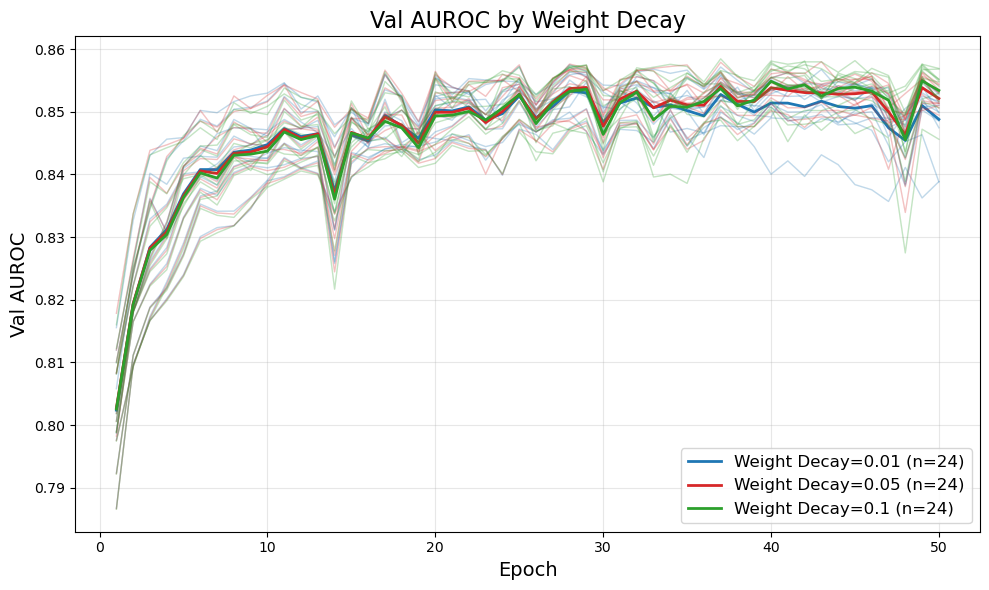

In [8]:
# Val AUROC
fig, ax = plt.subplots(figsize=(10, 6))
for i, wd_val in enumerate(weight_decay_values):
    subset = df[df['weight_decay'] == wd_val]
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            epochs = range(1, len(row['history_val_auroc']) + 1)
            ax.plot(epochs, row['history_val_auroc'], 
                    color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_aurocs = []
    max_len = 0
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            all_val_aurocs.append(row['history_val_auroc'])
            max_len = max(max_len, len(row['history_val_auroc']))
    if all_val_aurocs:
        padded = [auroc + [auroc[-1]] * (max_len - len(auroc)) if len(auroc) < max_len else auroc 
                 for auroc in all_val_aurocs]
        mean_auroc = np.mean([auroc[:max_len] for auroc in padded], axis=0)
        epochs = range(1, len(mean_auroc) + 1)
        ax.plot(epochs, mean_auroc, color=colors[i], linewidth=2, 
                label=f'Weight Decay={wd_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val AUROC', fontsize=14)
ax.set_title('Val AUROC by Weight Decay', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 3. Learning Rate Analysis


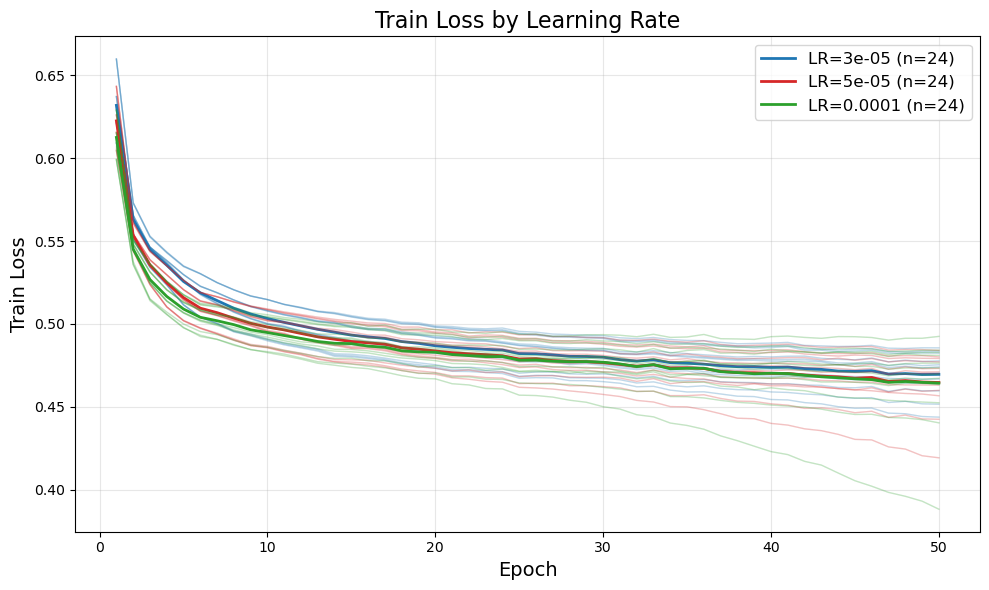

In [9]:
# Group by lr
lr_values = sorted(df['lr'].unique())
# Use highly distinct colors: blue, red, green
distinct_colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors = [distinct_colors[i % len(distinct_colors)] for i in range(len(lr_values))]

# Train Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, lr_val in enumerate(lr_values):
    subset = df[df['lr'] == lr_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_train_loss']) + 1)
        ax.plot(epochs, row['history_train_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_train_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_train_losses.append(row['history_train_loss'])
        max_len = max(max_len, len(row['history_train_loss']))
    if all_train_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_train_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'LR={lr_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Train Loss', fontsize=14)
ax.set_title('Train Loss by Learning Rate', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


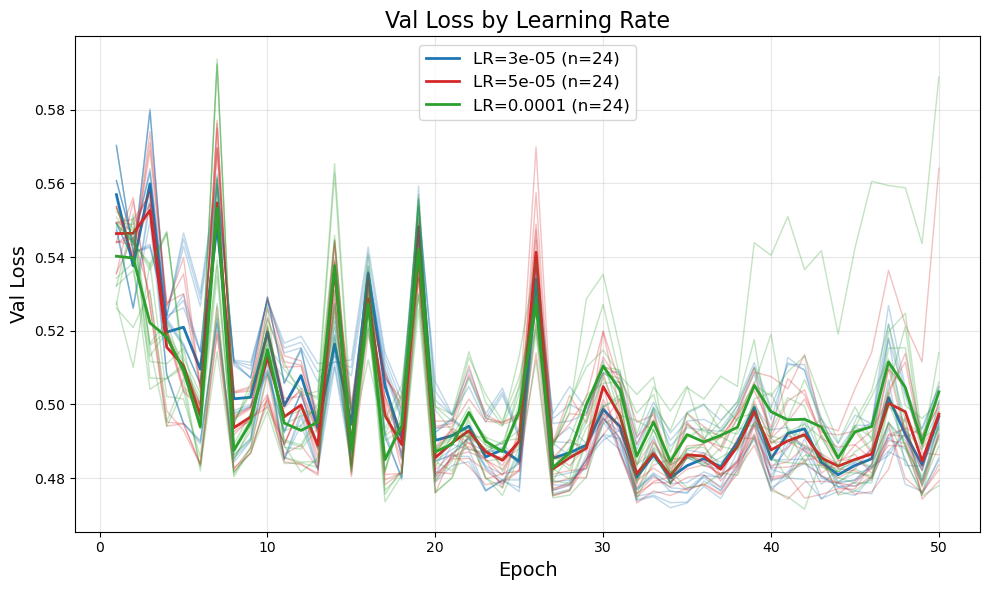

In [10]:
# Val Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, lr_val in enumerate(lr_values):
    subset = df[df['lr'] == lr_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_val_loss']) + 1)
        ax.plot(epochs, row['history_val_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_val_losses.append(row['history_val_loss'])
        max_len = max(max_len, len(row['history_val_loss']))
    if all_val_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_val_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'LR={lr_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val Loss', fontsize=14)
ax.set_title('Val Loss by Learning Rate', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


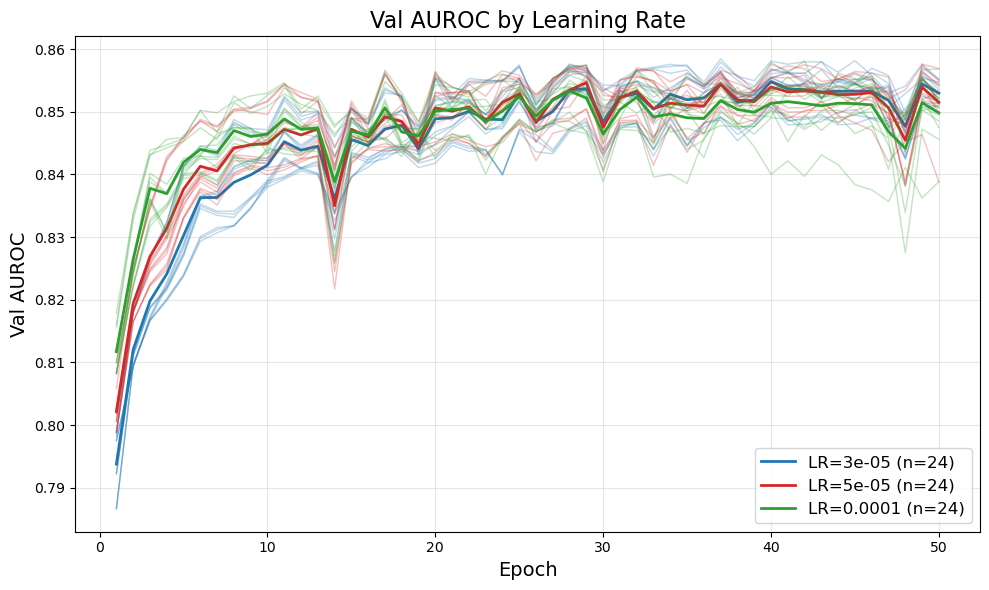

In [11]:
# Val AUROC
fig, ax = plt.subplots(figsize=(10, 6))
for i, lr_val in enumerate(lr_values):
    subset = df[df['lr'] == lr_val]
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            epochs = range(1, len(row['history_val_auroc']) + 1)
            ax.plot(epochs, row['history_val_auroc'], 
                    color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_aurocs = []
    max_len = 0
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            all_val_aurocs.append(row['history_val_auroc'])
            max_len = max(max_len, len(row['history_val_auroc']))
    if all_val_aurocs:
        padded = [auroc + [auroc[-1]] * (max_len - len(auroc)) if len(auroc) < max_len else auroc 
                 for auroc in all_val_aurocs]
        mean_auroc = np.mean([auroc[:max_len] for auroc in padded], axis=0)
        epochs = range(1, len(mean_auroc) + 1)
        ax.plot(epochs, mean_auroc, color=colors[i], linewidth=2, 
                label=f'LR={lr_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val AUROC', fontsize=14)
ax.set_title('Val AUROC by Learning Rate', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 4. Label Smoothing Analysis


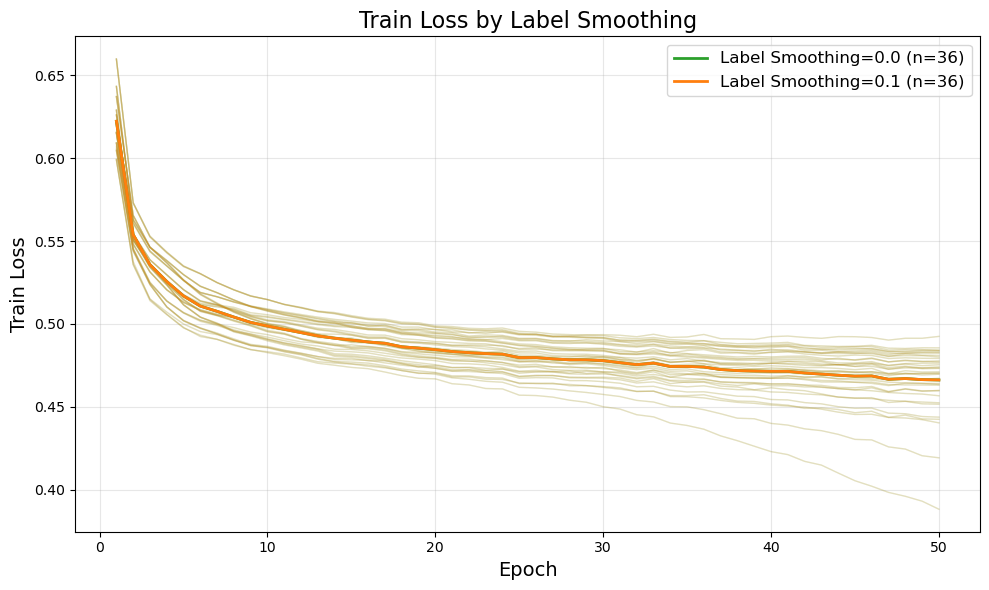

In [12]:
# Group by label_smoothing
label_smoothing_values = sorted(df['label_smoothing'].unique())
# Use highly distinct colors: blue, red
distinct_colors = ['#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors = [distinct_colors[i % len(distinct_colors)] for i in range(len(label_smoothing_values))]

# Train Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, ls_val in enumerate(label_smoothing_values):
    subset = df[df['label_smoothing'] == ls_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_train_loss']) + 1)
        ax.plot(epochs, row['history_train_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_train_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_train_losses.append(row['history_train_loss'])
        max_len = max(max_len, len(row['history_train_loss']))
    if all_train_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_train_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'Label Smoothing={ls_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Train Loss', fontsize=14)
ax.set_title('Train Loss by Label Smoothing', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


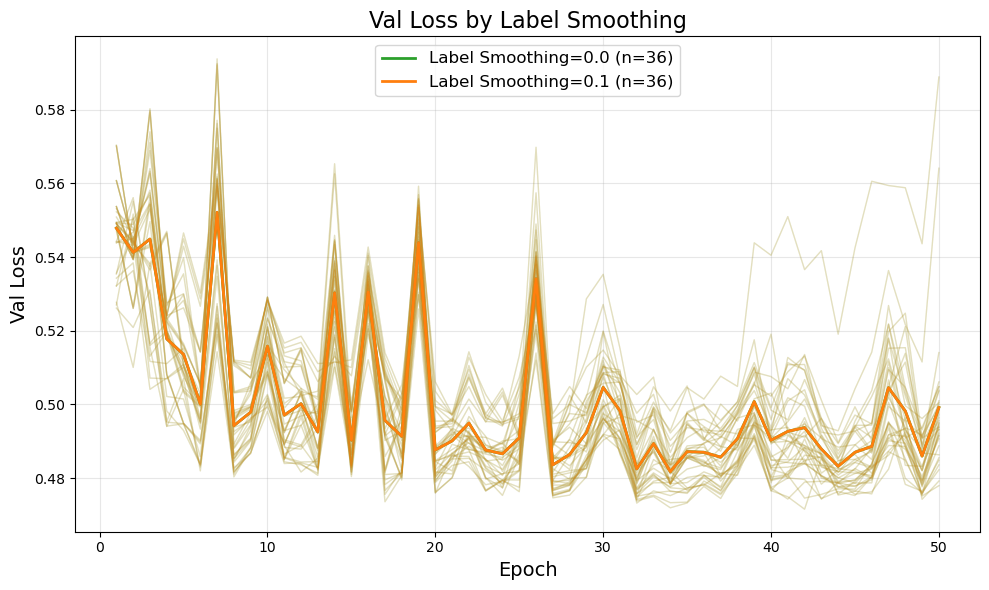

In [13]:
# Val Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, ls_val in enumerate(label_smoothing_values):
    subset = df[df['label_smoothing'] == ls_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_val_loss']) + 1)
        ax.plot(epochs, row['history_val_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_val_losses.append(row['history_val_loss'])
        max_len = max(max_len, len(row['history_val_loss']))
    if all_val_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_val_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'Label Smoothing={ls_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val Loss', fontsize=14)
ax.set_title('Val Loss by Label Smoothing', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


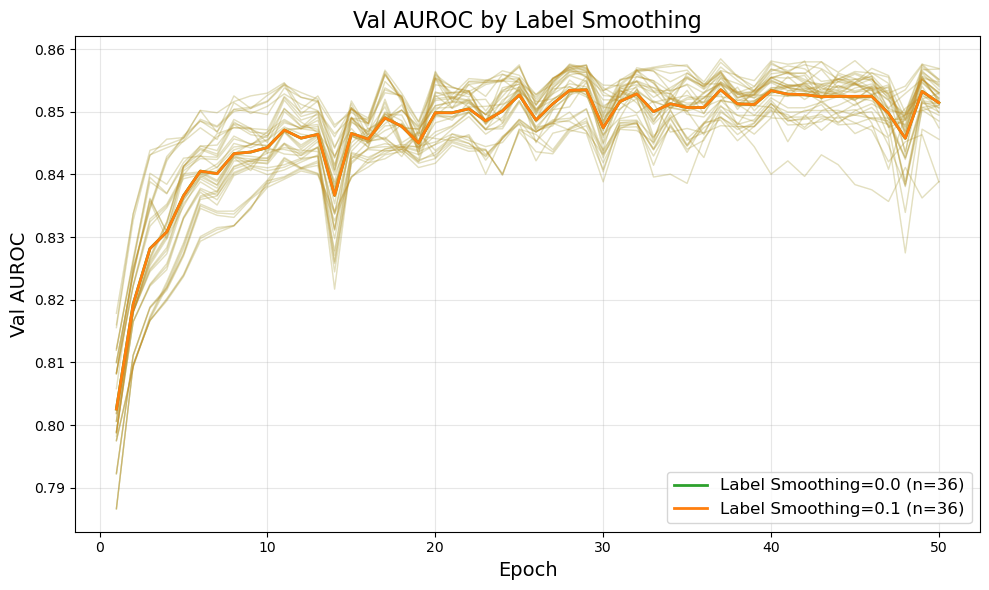

In [14]:
# Val AUROC
fig, ax = plt.subplots(figsize=(10, 6))
for i, ls_val in enumerate(label_smoothing_values):
    subset = df[df['label_smoothing'] == ls_val]
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            epochs = range(1, len(row['history_val_auroc']) + 1)
            ax.plot(epochs, row['history_val_auroc'], 
                    color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_aurocs = []
    max_len = 0
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            all_val_aurocs.append(row['history_val_auroc'])
            max_len = max(max_len, len(row['history_val_auroc']))
    if all_val_aurocs:
        padded = [auroc + [auroc[-1]] * (max_len - len(auroc)) if len(auroc) < max_len else auroc 
                 for auroc in all_val_aurocs]
        mean_auroc = np.mean([auroc[:max_len] for auroc in padded], axis=0)
        epochs = range(1, len(mean_auroc) + 1)
        ax.plot(epochs, mean_auroc, color=colors[i], linewidth=2, 
                label=f'Label Smoothing={ls_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val AUROC', fontsize=14)
ax.set_title('Val AUROC by Label Smoothing', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
